In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

data_file_path = os.getcwd()


# Constants
labelfont = {'fontname':'Calibri'}
ticksize = 10
labelsize = 12
titlesize = 18


data_file_path = r"C:\Users\govertsen.k\Northeastern University\Community Resilience in Extreme Temperatures - Data\Vulnerability Mapping\Weather Files\CSV"
data_file_path = data_file_path.replace(os.sep, '/')

extension = 'csv'
os.chdir(data_file_path)
result = glob.glob('*.{}'.format(extension))

weather = pd.DataFrame()

for each_file in result:
    # Only keep the columns we need (Date, Houly Temperature, Hourly Humidity)
    this_weather_file = pd.read_csv(each_file,low_memory=False)
    this_weather_file = this_weather_file.assign(Station=each_file[:-4])
    this_weather_file = this_weather_file[['DATE','Station','HourlyDryBulbTemperature','HourlyDewPointTemperature','HourlyRelativeHumidity','HourlyStationPressure','HourlyWindDirection','HourlyWindSpeed','HourlySkyConditions']]
    weather = pd.concat([weather,this_weather_file])

In [2]:
stations = pd.unique(weather['Station'])
for each_station in stations:
    print('The start date for ' + str(each_station) + ' is ' + weather[weather['Station']== each_station].iloc[0]['DATE'],'\n')
    print('The end date for ' + str(each_station) + ' is ' + weather[weather['Station']== each_station].iloc[-1]['DATE'],'\n')

The start date for 72509594746 is 1973-01-01T01:00:00 

The end date for 72509594746 is 2010-07-31T18:54:00 

The start date for 72510094746 is 2005-01-01T00:54:00 

The end date for 72510094746 is 2023-01-17T02:54:00 

The start date for 99999994746 is 1949-01-01T06:00:00 

The end date for 99999994746 is 1972-12-31T16:00:00 



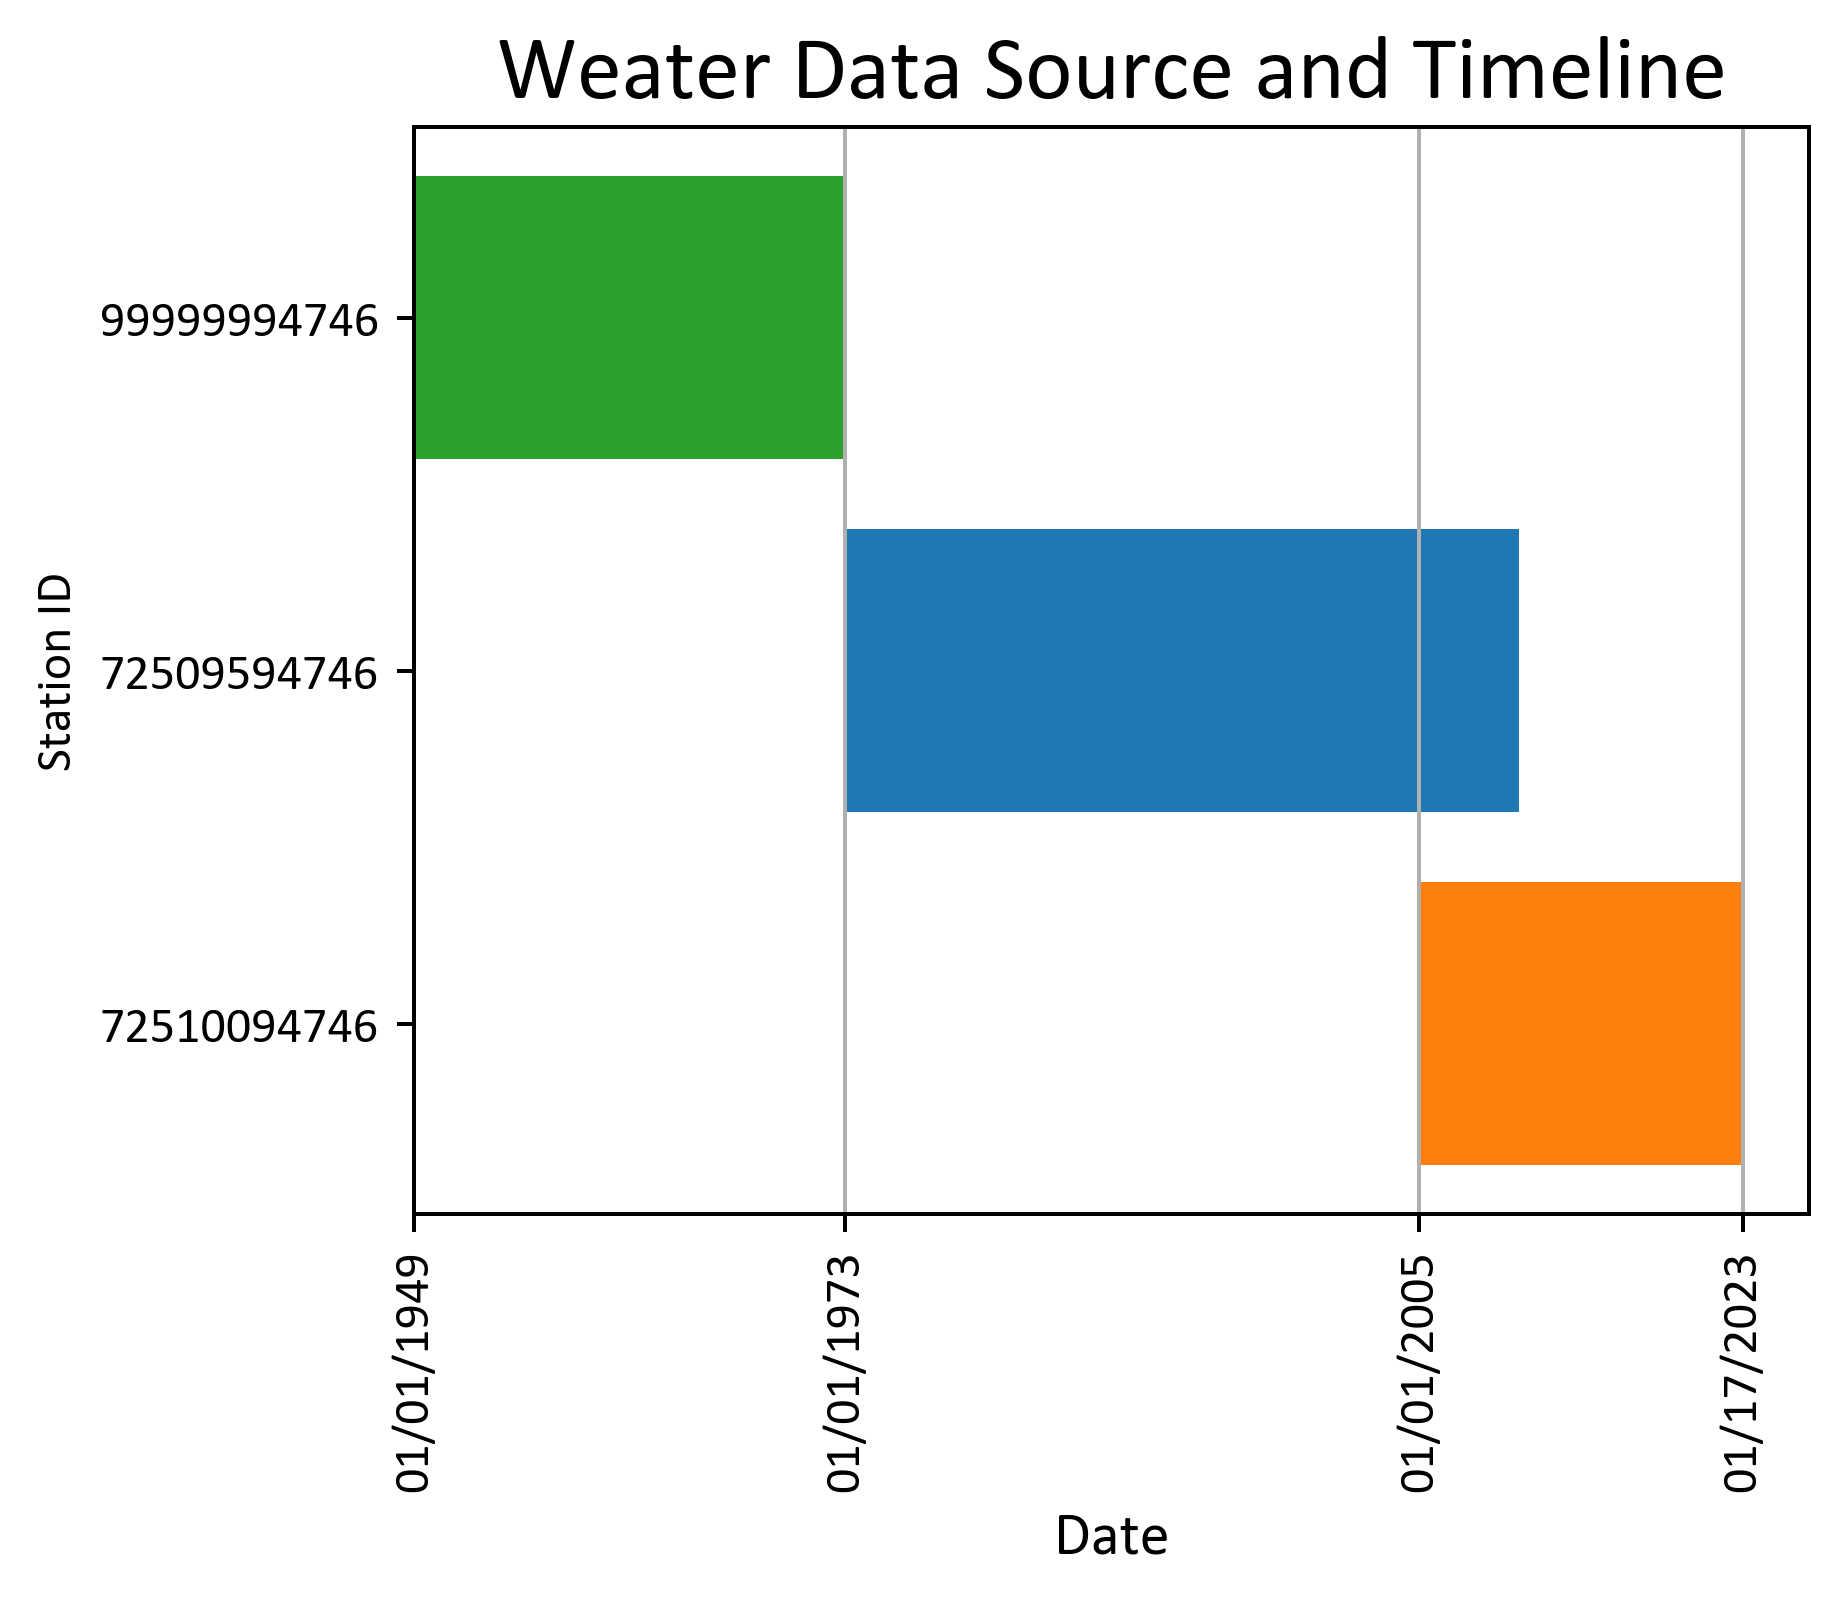

In [3]:
stations = pd.DataFrame()
stations.index = pd.unique(weather['Station'])
stations['start label'] = ""
stations['start'] = ""
stations['end'] = ""
stations['end label'] = ""
stations['gap'] = 0
stations['duration'] =0
stations['order'] = 0
id = 1
f1=plt.figure(figsize=(5,4),dpi=360)
for each_station in stations.index:
    stations.loc[stations.index == each_station,'start'] = pd.to_datetime(weather[weather['Station']== each_station].iloc[0]['DATE']) 
    stations.loc[stations.index == each_station,'end'] = pd.to_datetime(weather[weather['Station']== each_station].iloc[-1]['DATE'])
    if id == 1:
        og_start = stations['start'][each_station]
        stations.loc[stations.index == each_station,'gap'] = 0
    else:
        gap = stations['start'][each_station] - og_start
        stations.loc[stations.index == each_station,'gap'] =  gap.days
    duration = stations['end'][each_station] - stations['start'][each_station] 
    stations.loc[stations.index == each_station,'duration'] = duration.days

    if each_station == '99999994746':
        stations.loc[stations.index == each_station,'order'] = 3
    elif each_station == '72509594746':
        stations.loc[stations.index == each_station,'order'] = 2
    else:
        stations.loc[stations.index == each_station,'order'] = 1
    plt.barh(y=stations['order'][each_station],width=stations['duration'][each_station],left=stations['gap'][each_station])
    id = id+1
    stations.loc[stations.index == each_station,'start label'] = stations['start'][each_station].strftime("%m/%d/%Y")
    stations.loc[stations.index == each_station,'end label'] = stations['end'][each_station].strftime("%m/%d/%Y")
stations = stations.sort_values(by='start')
x_ticks = list()
x_tick_labels = list()
for each_station in stations.index:
    x_ticks.append(stations['gap'][each_station])
    x_tick_labels.append(stations['start label'][each_station])
    if each_station == stations.index[-1]:
        x_ticks.append(stations['gap'][each_station] + stations['duration'][each_station])
        x_tick_labels.append(stations['end label'][each_station])
# plt.xticks(x_ticks)
plt.yticks([])
plt.ylabel('Station ID', fontsize=ticksize,**labelfont)
plt.yticks(stations['order'],stations.index,fontsize=ticksize,**labelfont)
plt.xlabel('Date',fontsize=labelsize,**labelfont)
plt.xticks(x_ticks,x_tick_labels,rotation = 90,fontsize=10,**labelfont)
plt.title('Weater Data Source and Timeline',fontsize=titlesize,**labelfont)
plt.grid(axis='x')
plt.savefig('output/weather_timeline.png',bbox_inches="tight")

In [4]:
# set date as datetime
weather['DATE'] = pd.to_datetime(weather['DATE'])
w1 = weather.loc[weather['DATE'] < pd.to_datetime(x_tick_labels[1])]
w2 = weather.loc[(weather['DATE'] >= pd.to_datetime(x_tick_labels[1])) & (weather['DATE'] < pd.to_datetime(x_tick_labels[2]))]
w3 = weather.loc[(weather['DATE'] >= pd.to_datetime(x_tick_labels[2])) & (weather['Station'] == stations.index[-1])]
weather = pd.DataFrame()
weather = pd.concat([w1,w2,w3],ignore_index=True)
weather["DATE-H"] = weather["DATE"].dt.round("H")

In [5]:
weather['Num NA'] = weather.isnull().sum(axis=1)
weather = weather.sort_values('Num NA', ascending=False).drop_duplicates('DATE-H').sort_index()
weather = weather.reset_index(drop=True)

In [6]:
data = pd.DataFrame()
data['time_range'] = pd.date_range(weather['DATE'][0],weather['DATE'][len(weather)-1],freq='H')
data['NA']=0
data.loc[~data['time_range'].isin(weather['DATE-H']),'NA'] = 1

data_2 = pd.DataFrame()
data_2['Year'] = data['time_range'].dt.year.unique()
data_2['Missing'] = 0

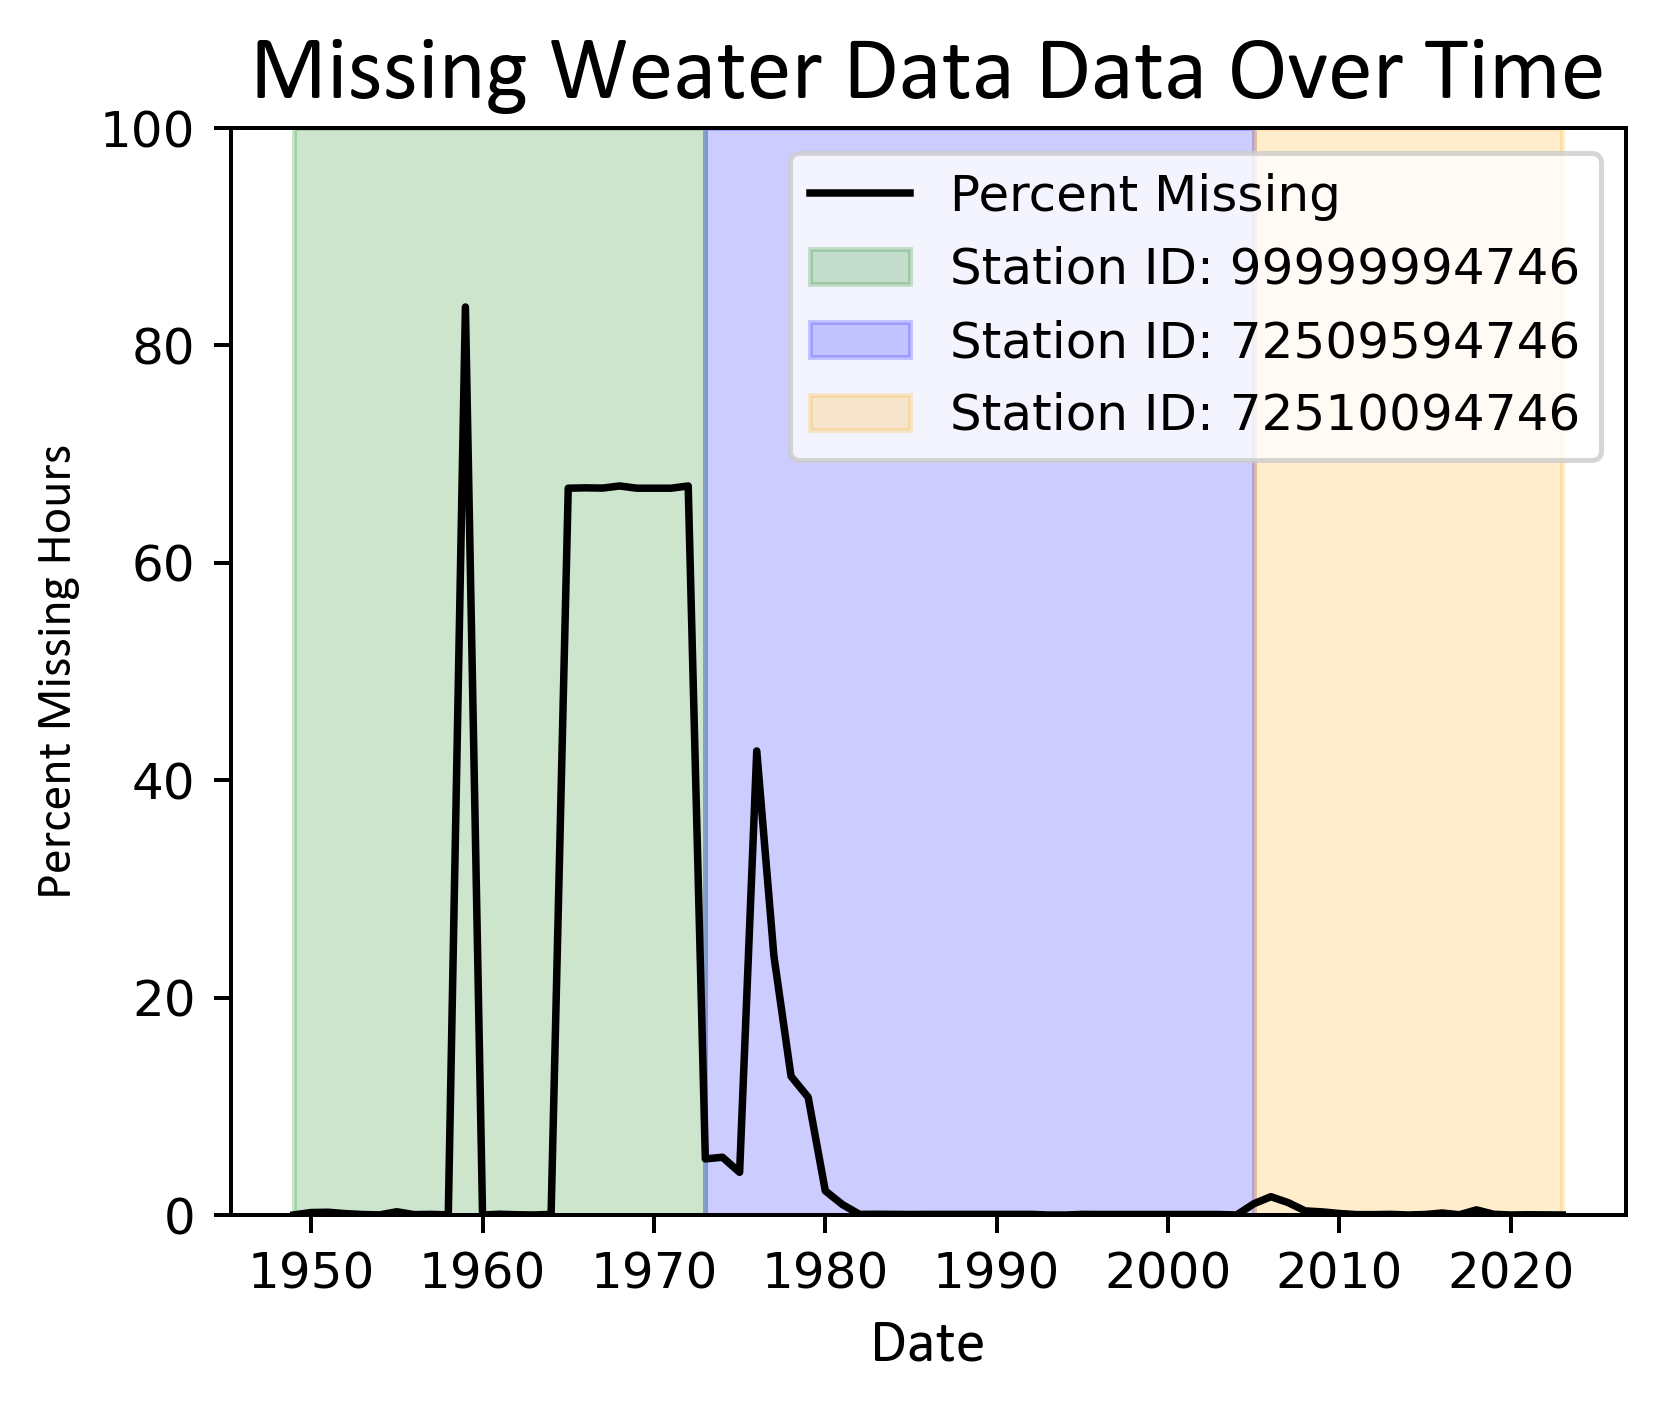

In [7]:
hrs_in_yr = 24*364
percent=100
# fig, axs = plt.subplots()
f2=plt.figure(figsize=(5,4),dpi=360)
for each_year in data_2['Year']:
    data_2.loc[data_2['Year'] == each_year,'Missing'] = percent*data.loc[data['time_range'].dt.year == each_year]['NA'].sum()/hrs_in_yr
plt.plot(data_2['Year'],data_2['Missing'],color='k',label='Percent Missing')
plt.ylabel('Percent Missing Hours', fontsize=ticksize,**labelfont)
plt.ylim([0,100])
plt.xlabel('Date',fontsize=labelsize,**labelfont)
plt.title('Missing Weater Data Data Over Time',fontsize=titlesize,**labelfont)
plt.fill_between([pd.to_datetime(x_tick_labels[0]).year,pd.to_datetime(x_tick_labels[1]).year],[percent,percent],color='g',alpha=0.2,label = str('Station ID: ' + stations.index[0]))
plt.fill_between([pd.to_datetime(x_tick_labels[1]).year,pd.to_datetime(x_tick_labels[2]).year],[percent,percent],color='blue',alpha=0.2,label = str('Station ID: ' + stations.index[1]))
plt.fill_between([pd.to_datetime(x_tick_labels[2]).year,pd.to_datetime(x_tick_labels[3]).year],[percent,percent],color='orange',alpha=0.2,label = str('Station ID: ' +stations.index[2]))
plt.legend()
#plt.vlines(x = pd.to_datetime(x_tick_labels).year, colors = 'k',ymin=0,ymax=8000)
#plt.xticks(pd.to_datetime(x_tick_labels).year,str(pd.to_datetime(x_tick_labels).year),rotation = 90,fontsize=10,**labelfont)

plt.savefig('output/weather_missing.png',bbox_inches="tight")

In [8]:
# Keep Only Weather Data > 1980 and < 2022
new_weather = weather.loc[(weather['DATE-H'].dt.year >= 1980) & (weather['DATE-H'].dt.year <= 2022)]
new_weather = new_weather.reset_index(drop = True)
# Fill in Missing Ones 
data = pd.DataFrame()
data['time_range'] = pd.date_range(new_weather['DATE'][0],new_weather['DATE'][len(new_weather)-1],freq='H')
missing_data = pd.DataFrame()
missing_data['DATE-H'] = data.loc[~data['time_range'].isin(new_weather['DATE-H'])]['time_range']
#for each_missing_date in missing_times:
    

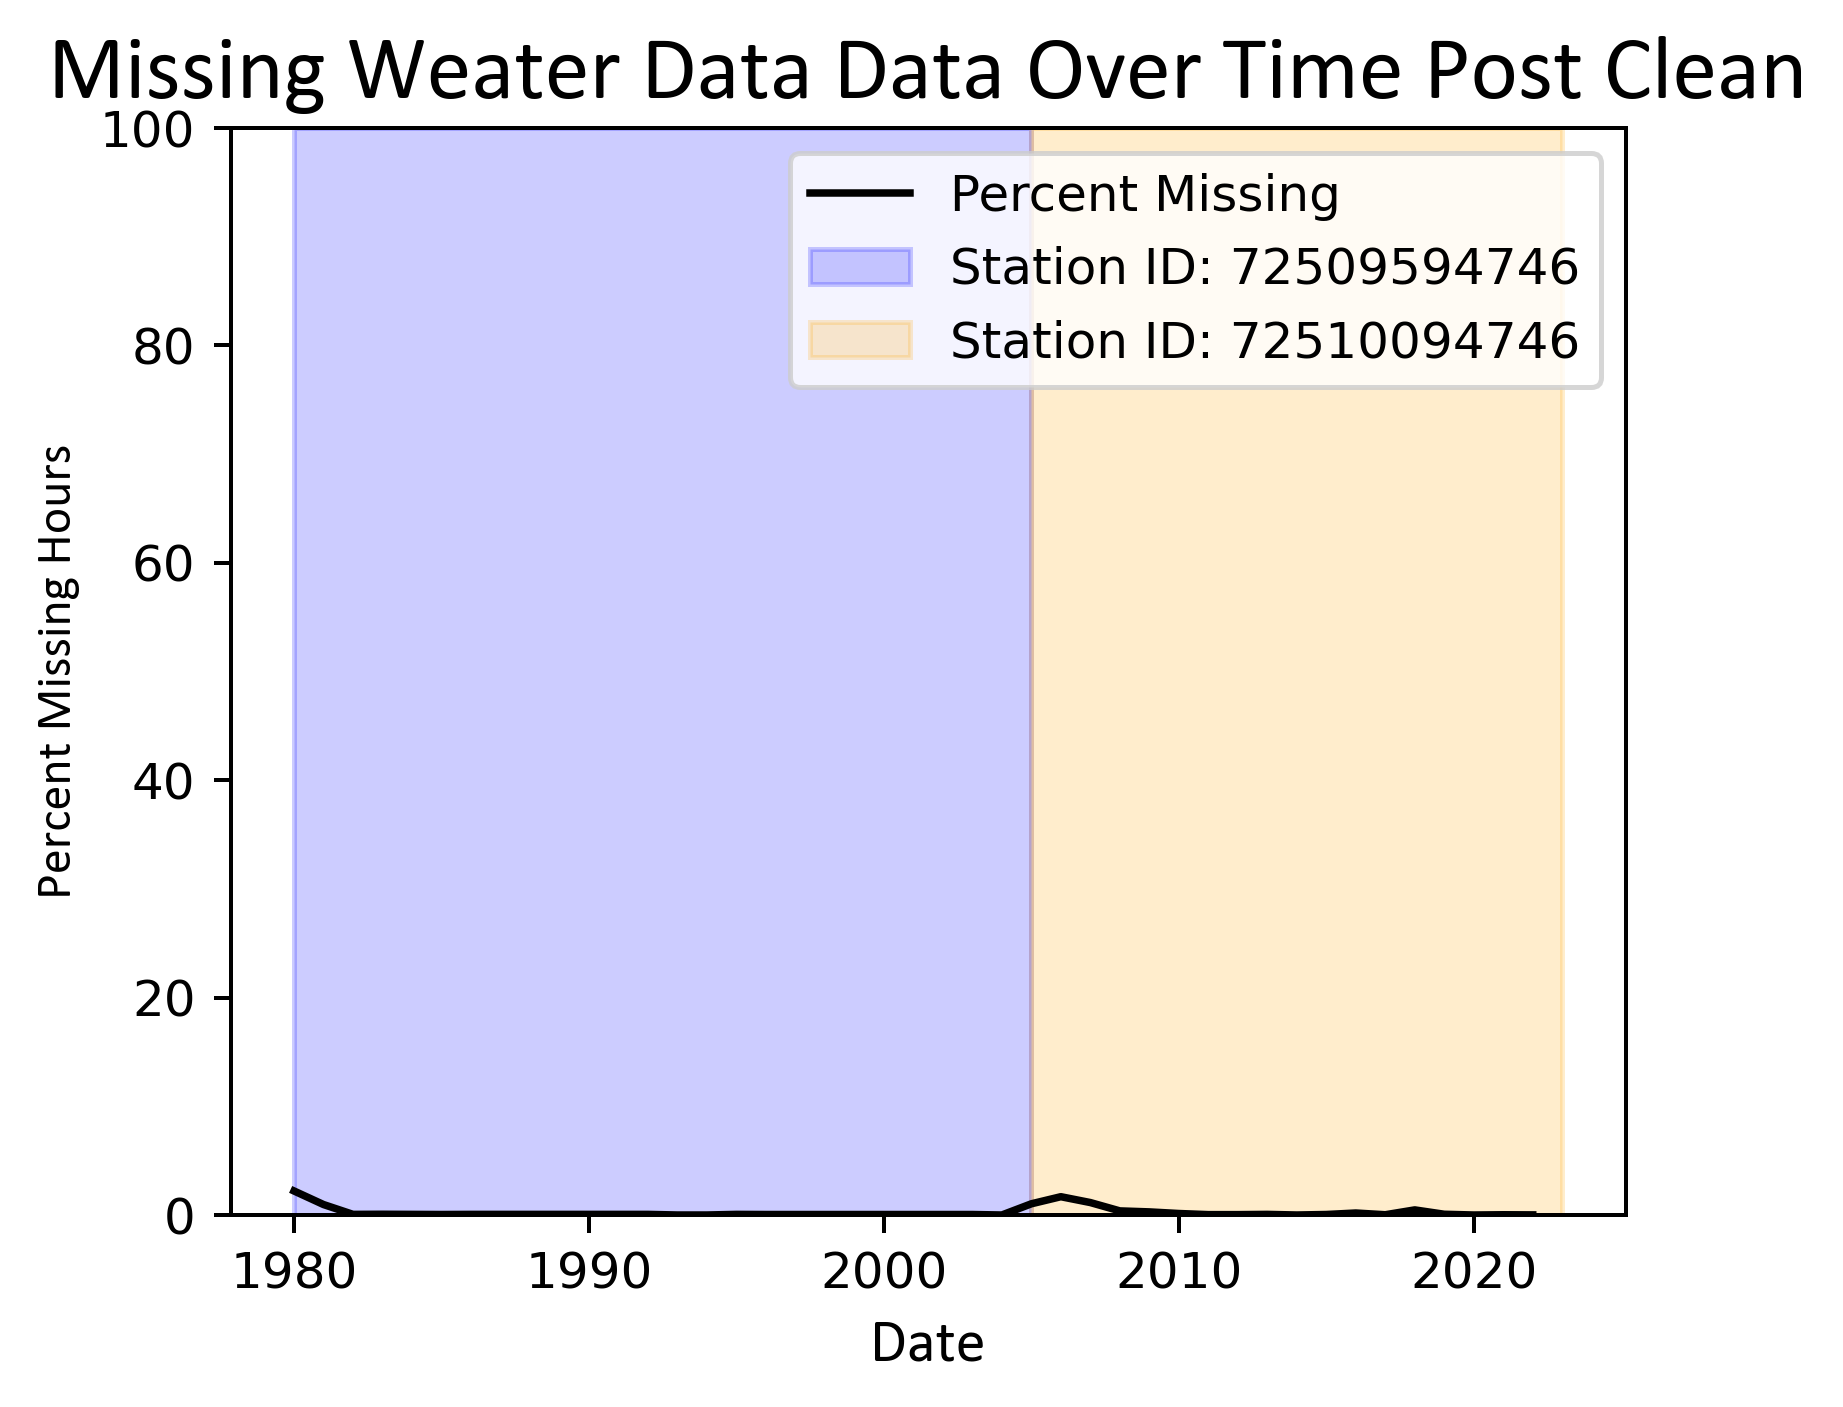

In [9]:
data = pd.DataFrame()
data['time_range'] = pd.date_range(new_weather['DATE'][0],new_weather['DATE'][len(new_weather)-1],freq='H')
data['NA']=0
data.loc[~data['time_range'].isin(new_weather['DATE-H']),'NA'] = 1

data_2 = pd.DataFrame()
data_2['Year'] = data['time_range'].dt.year.unique()
data_2['Missing'] = 0

f3=plt.figure(figsize=(5,4),dpi=360)
# fig, axs = plt.subplots()
for each_year in data_2['Year']:
    data_2.loc[data_2['Year'] == each_year,'Missing'] = percent*data.loc[data['time_range'].dt.year == each_year]['NA'].sum()/hrs_in_yr
plt.plot(data_2['Year'],data_2['Missing'],color='k',label='Percent Missing')
plt.ylabel('Percent Missing Hours', fontsize=ticksize,**labelfont)
plt.ylim([0,100])
plt.xlabel('Date',fontsize=labelsize,**labelfont)
plt.title('Missing Weater Data Data Over Time Post Clean',fontsize=titlesize,**labelfont)
#plt.fill_between([pd.to_datetime(x_tick_labels[0]).year,pd.to_datetime(x_tick_labels[1]).year],[percent,percent],color='g',alpha=0.2,label = str('Station ID: ' + stations.index[0]))
plt.fill_between([pd.to_datetime('1980').year,pd.to_datetime(x_tick_labels[2]).year],[percent,percent],color='blue',alpha=0.2,label = str('Station ID: ' + stations.index[1]))
plt.fill_between([pd.to_datetime(x_tick_labels[2]).year,pd.to_datetime(x_tick_labels[3]).year],[percent,percent],color='orange',alpha=0.2,label = str('Station ID: ' +stations.index[2]))
plt.legend()
#plt.vlines(x = pd.to_datetime(x_tick_labels).year, colors = 'k',ymin=0,ymax=8000)
#plt.xticks(pd.to_datetime(x_tick_labels).year,str(pd.to_datetime(x_tick_labels).year),rotation = 90,fontsize=10,**labelfont)

plt.savefig('output/weather_missing_2.png',bbox_inches="tight")

In [10]:
new_weather = new_weather.drop(columns=['DATE','Num NA'])

In [11]:
missing_data['Station'] = 'FILLED'
filled_weather = pd.concat([new_weather,missing_data])
filled_weather = filled_weather.sort_values(by='DATE-H',ascending=True)
filled_weather = filled_weather.fillna(method='ffill')
filled_weather = filled_weather.reset_index(drop = True)

In [12]:
# Add Heat Index Value to File
heat_index = pd.read_csv(data_file_path +'/heatindex/heatindex.csv')
filled_weather['HI'] = 0

for each_temp in range(80,112,2):
    for each_rh in range(40,105,5):      
        HI = heat_index.loc[(heat_index['RH'] == each_rh),str(each_temp)]
        filled_weather.loc[(np.floor(filled_weather['HourlyRelativeHumidity'].astype(int)/5)*5 == each_rh) & (np.floor(filled_weather["HourlyDryBulbTemperature"].astype(int)/2)*2 == each_temp),["HI"]] = int(HI)

In [13]:
# Save to CSV so this can be accessed in other notebooks
filled_weather.to_csv(data_file_path + '/output/filled_weather.csv',index=False)  

In [14]:
# Create summary table
summary_weather = pd.DataFrame()

s_year = min(filled_weather['DATE-H'].dt.year)
e_year = max(filled_weather['DATE-H'].dt.year)

s_hi = 1
e_hi = 4

# for each year
summary_weather["years"] = range(s_year,e_year + 1,1)

for each_year in range(s_year,e_year + 1,1):
    for each_hi in range(s_hi,e_hi + 1,1):
        summary_weather.loc[summary_weather['years']==each_year,[each_hi]] = len(filled_weather.loc[(filled_weather["HI"] == each_hi) & (filled_weather['DATE-H'].dt.year == each_year)])

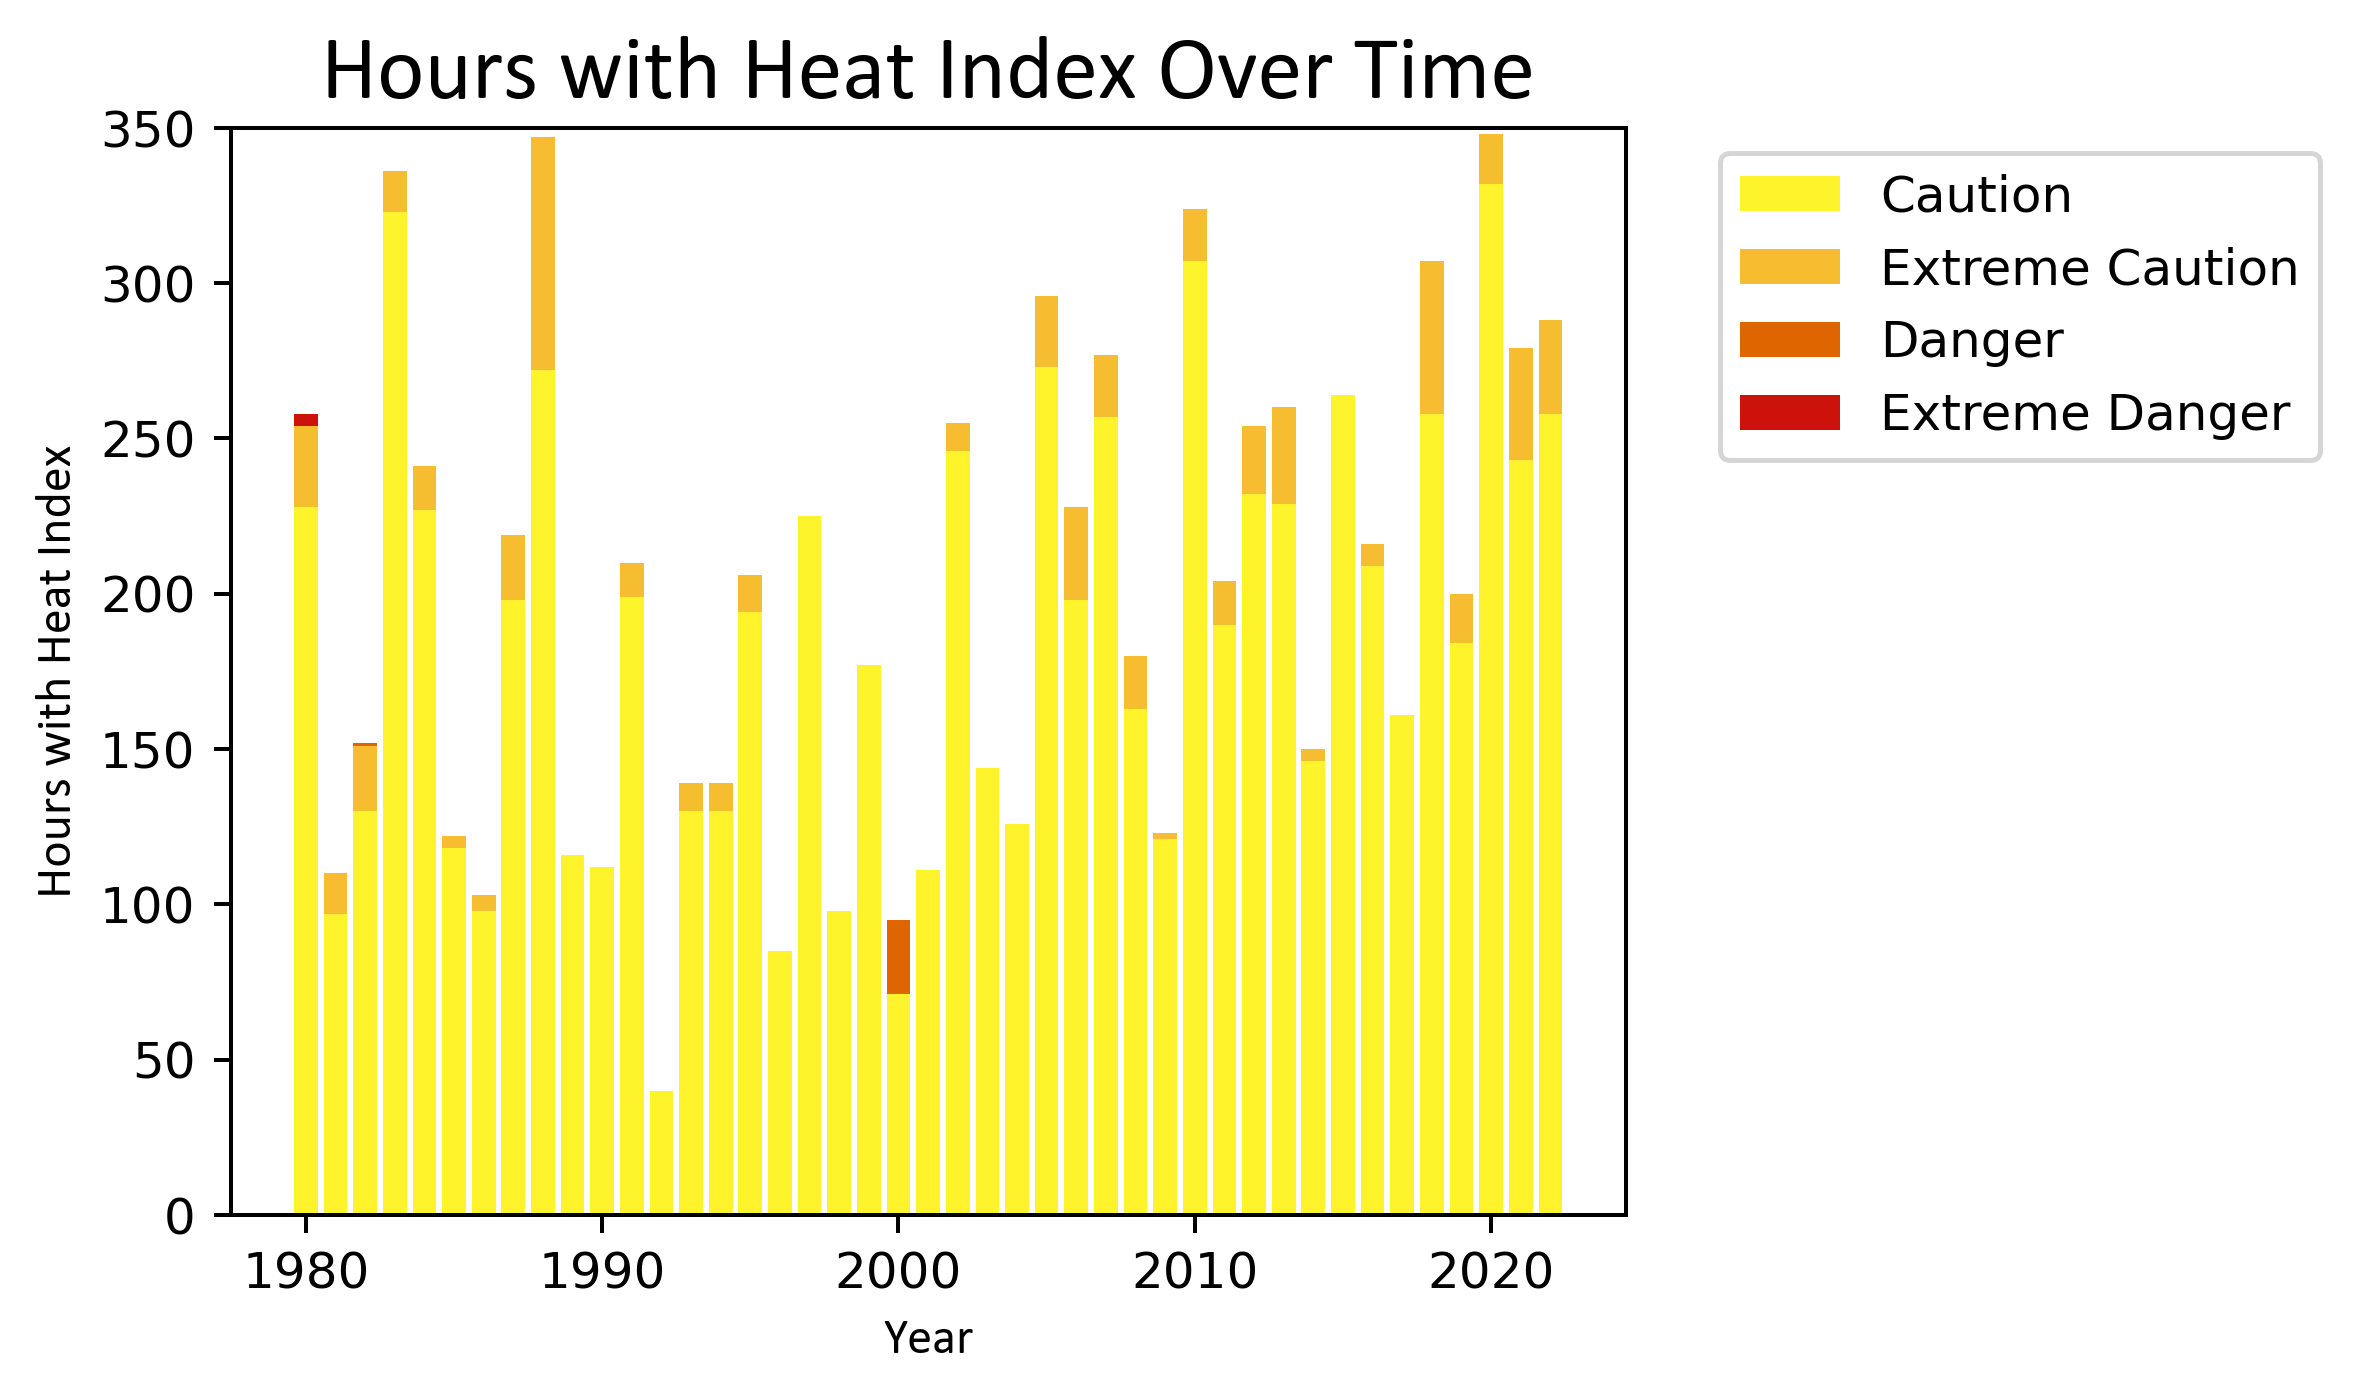

<Figure size 432x288 with 0 Axes>

In [15]:
f4=plt.figure(figsize=(5,4),dpi=360)
plt.bar(summary_weather['years'], summary_weather[1], color='#fff32b',label='Caution')
plt.bar(summary_weather['years'], summary_weather[2], bottom=summary_weather[1], color='#f6bd30',label='Extreme Caution')
plt.bar(summary_weather['years'], summary_weather[3], bottom=summary_weather[1]+summary_weather[2], color='#df6500',label='Danger')
plt.bar(summary_weather['years'], summary_weather[4], bottom=summary_weather[1]+summary_weather[2]+summary_weather[3], color='#cd120b',label='Extreme Danger')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylim([0,350])
plt.ylabel('Hours with Heat Index',fontsize=ticksize,**labelfont)
plt.xlabel('Year',fontsize=ticksize,**labelfont)
plt.title('Hours with Heat Index Over Time',fontsize=titlesize,**labelfont)
plt.show()
plt.savefig('output/historical_heat_index.png',bbox_inches="tight")
# change colors to match
# combine for total heat hours

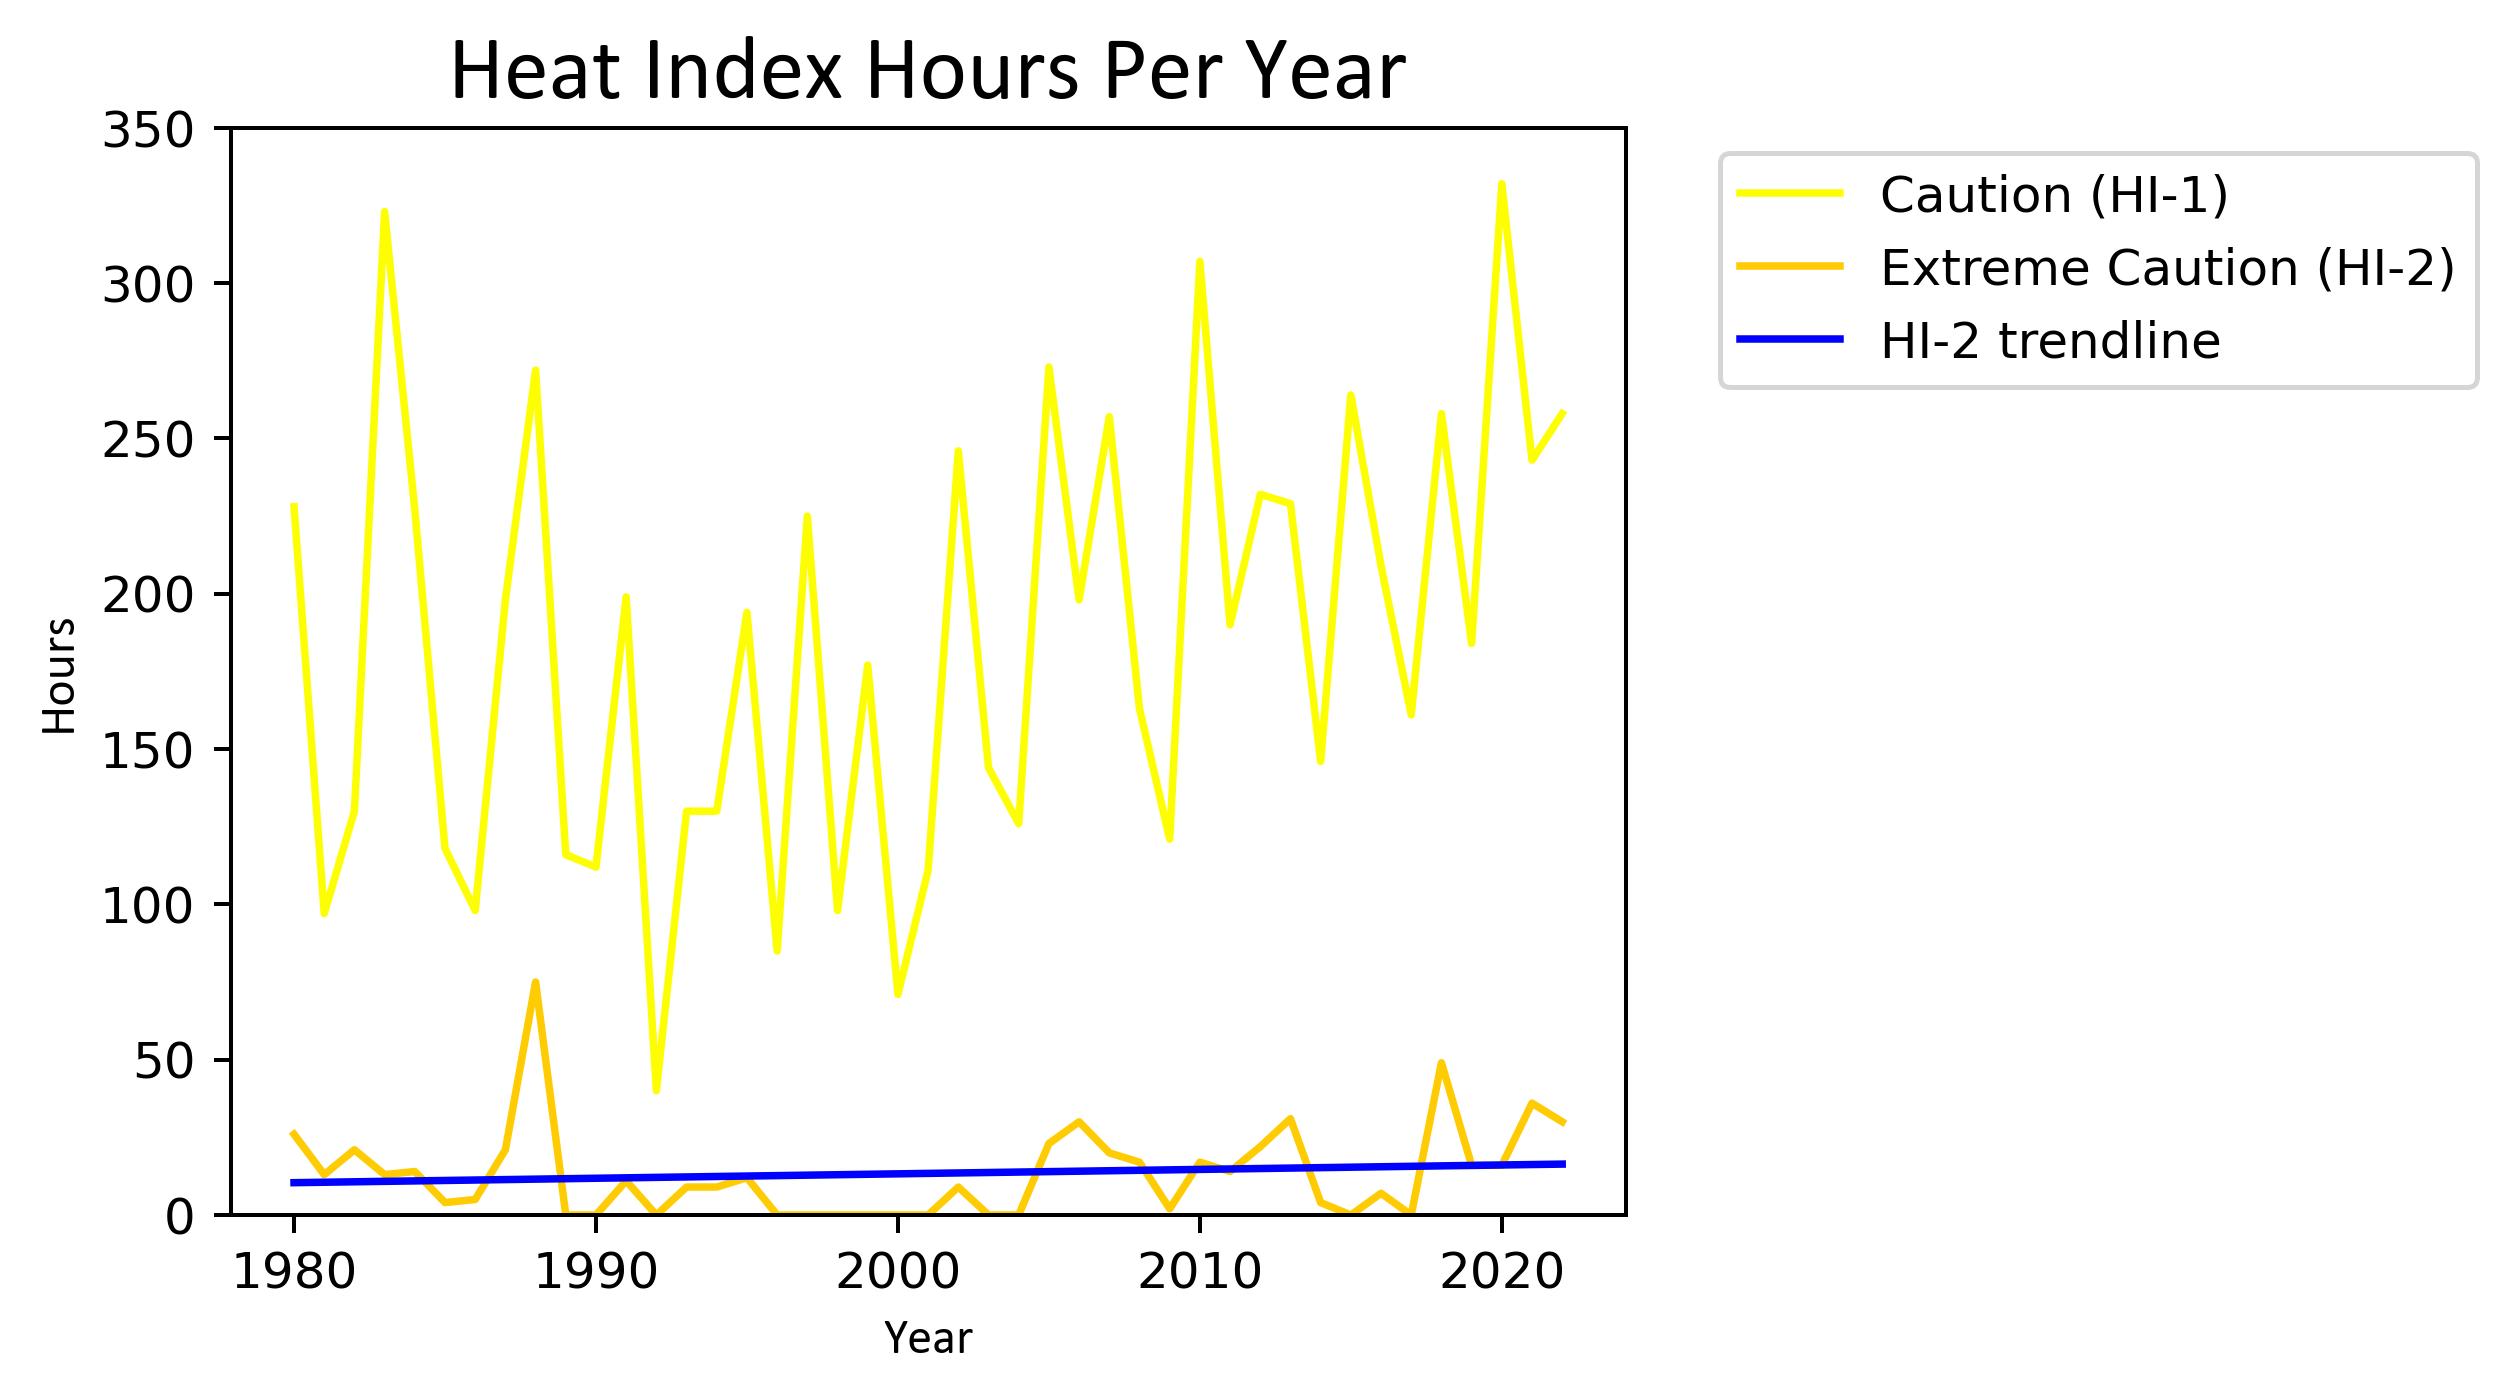

<Figure size 432x288 with 0 Axes>

In [16]:
f5=plt.figure(figsize=(5,4),dpi=360)
plt.plot(summary_weather['years'], summary_weather[1], color='#fefe02',label='Caution (HI-1)')
plt.plot(summary_weather['years'], summary_weather[2], color='#ffcb03',label='Extreme Caution (HI-2)')

#calculate equation for trendline
z = np.polyfit(summary_weather['years'], summary_weather[1], 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(summary_weather['years'], p(summary_weather['years']),color = 'k',label='HI-1 trendline')

#calculate equation for trendline
z = np.polyfit(summary_weather['years'], summary_weather[2], 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(summary_weather['years'], p(summary_weather['years']),color = 'b',label='HI-2 trendline')
plt.title('Heat Index Hours Per Year',fontsize=titlesize,**labelfont)
plt.xlabel('Year',fontsize=ticksize,**labelfont)
plt.ylabel('Hours',fontsize=ticksize,**labelfont)
plt.ylim([0,350])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
plt.savefig('output/heat_index_trends.png',bbox_inches="tight")

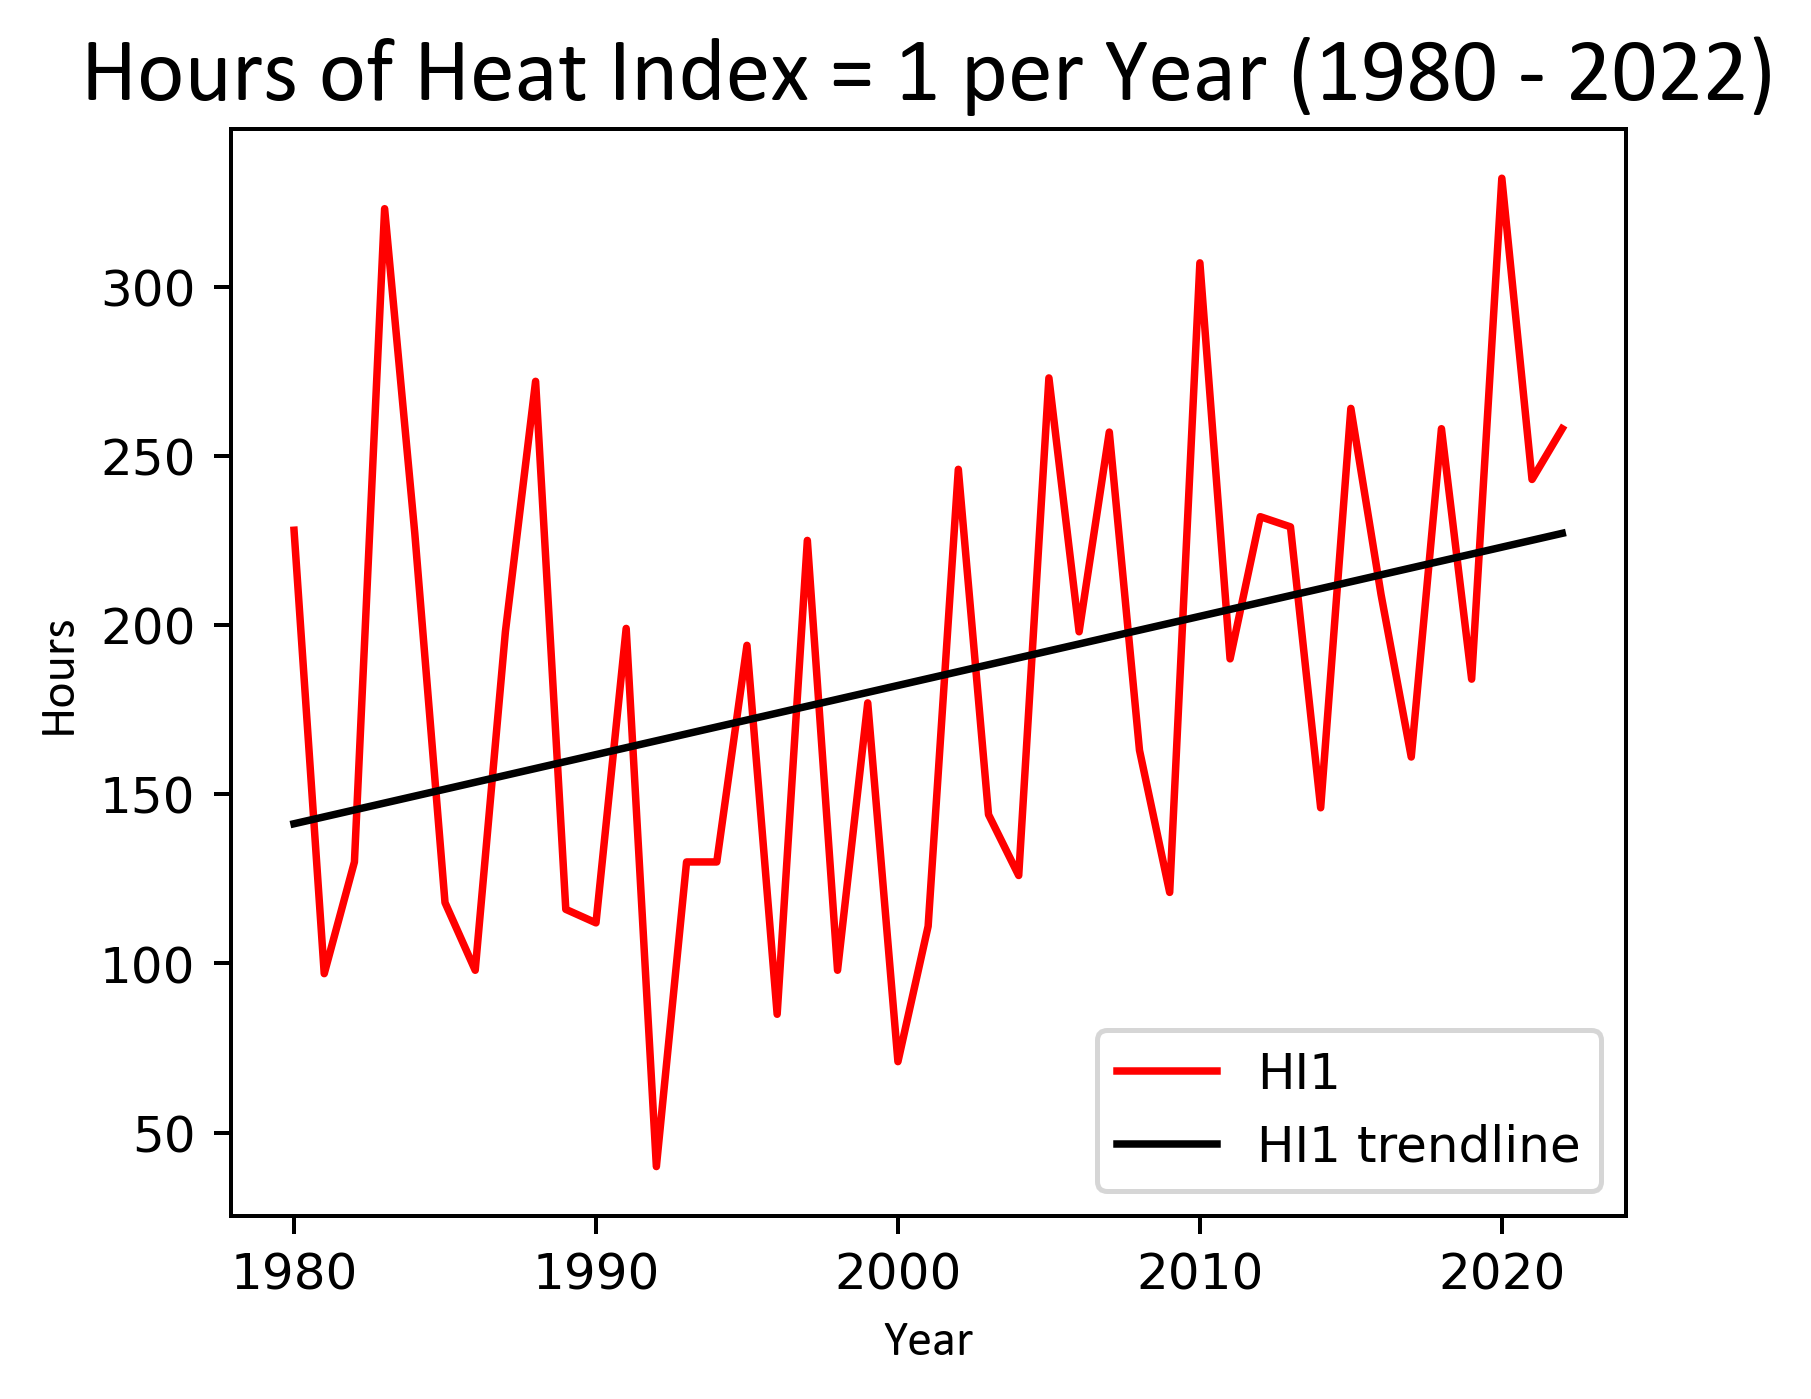

<Figure size 432x288 with 0 Axes>

In [17]:
f6=plt.figure(figsize=(5,4),dpi=360)

plt.plot(summary_weather['years'], summary_weather[1], color='r',label="HI1")


#calculate equation for trendline
z = np.polyfit(summary_weather['years'], summary_weather[1], 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(summary_weather['years'], p(summary_weather['years']),color = 'k',label='HI1 trendline')

plt.title('Hours of Heat Index = 1 per Year (1980 - 2022)',fontsize=titlesize,**labelfont)
plt.xlabel('Year',fontsize=ticksize,**labelfont)
plt.ylabel('Hours',fontsize=ticksize,**labelfont)
plt.legend(loc = 'lower right')
plt.show()
plt.savefig('output/heat_index_1_trend.png',bbox_inches="tight")

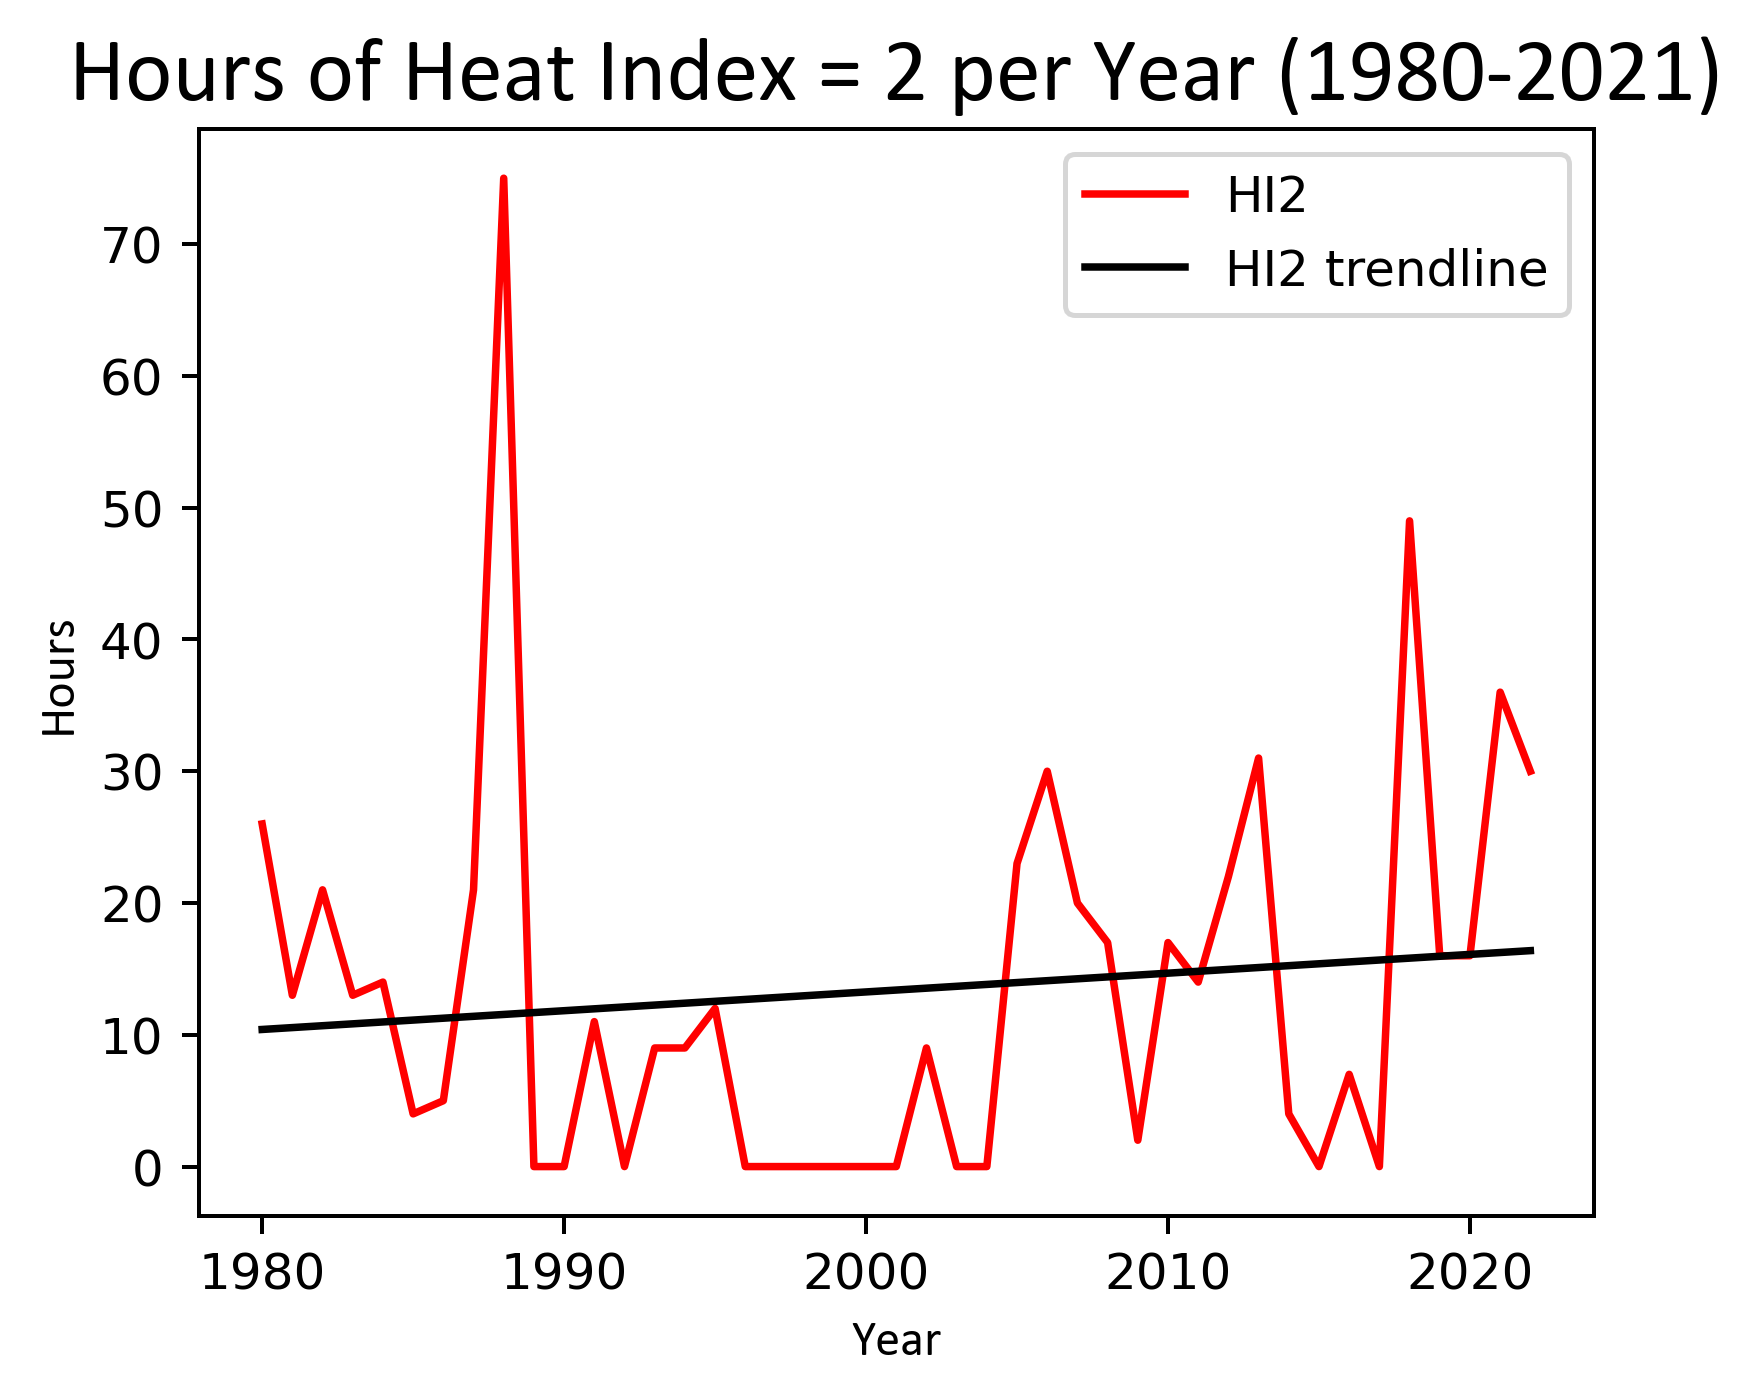

<Figure size 432x288 with 0 Axes>

In [18]:
f7=plt.figure(figsize=(5,4),dpi=360)

plt.plot(summary_weather['years'], summary_weather[2], color='r',label="HI2")

#calculate equation for trendline
z = np.polyfit(summary_weather['years'], summary_weather[2], 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(summary_weather['years'], p(summary_weather['years']),color = 'k',label="HI2 trendline")
plt.title('Hours of Heat Index = 2 per Year (1980-2021)',fontsize=titlesize,**labelfont)
plt.xlabel('Year',fontsize=ticksize,**labelfont)
plt.ylabel('Hours',fontsize=ticksize,**labelfont)
plt.legend(loc='upper right')
plt.show()
plt.savefig('output/heat_index_2_trend.png',bbox_inches="tight")

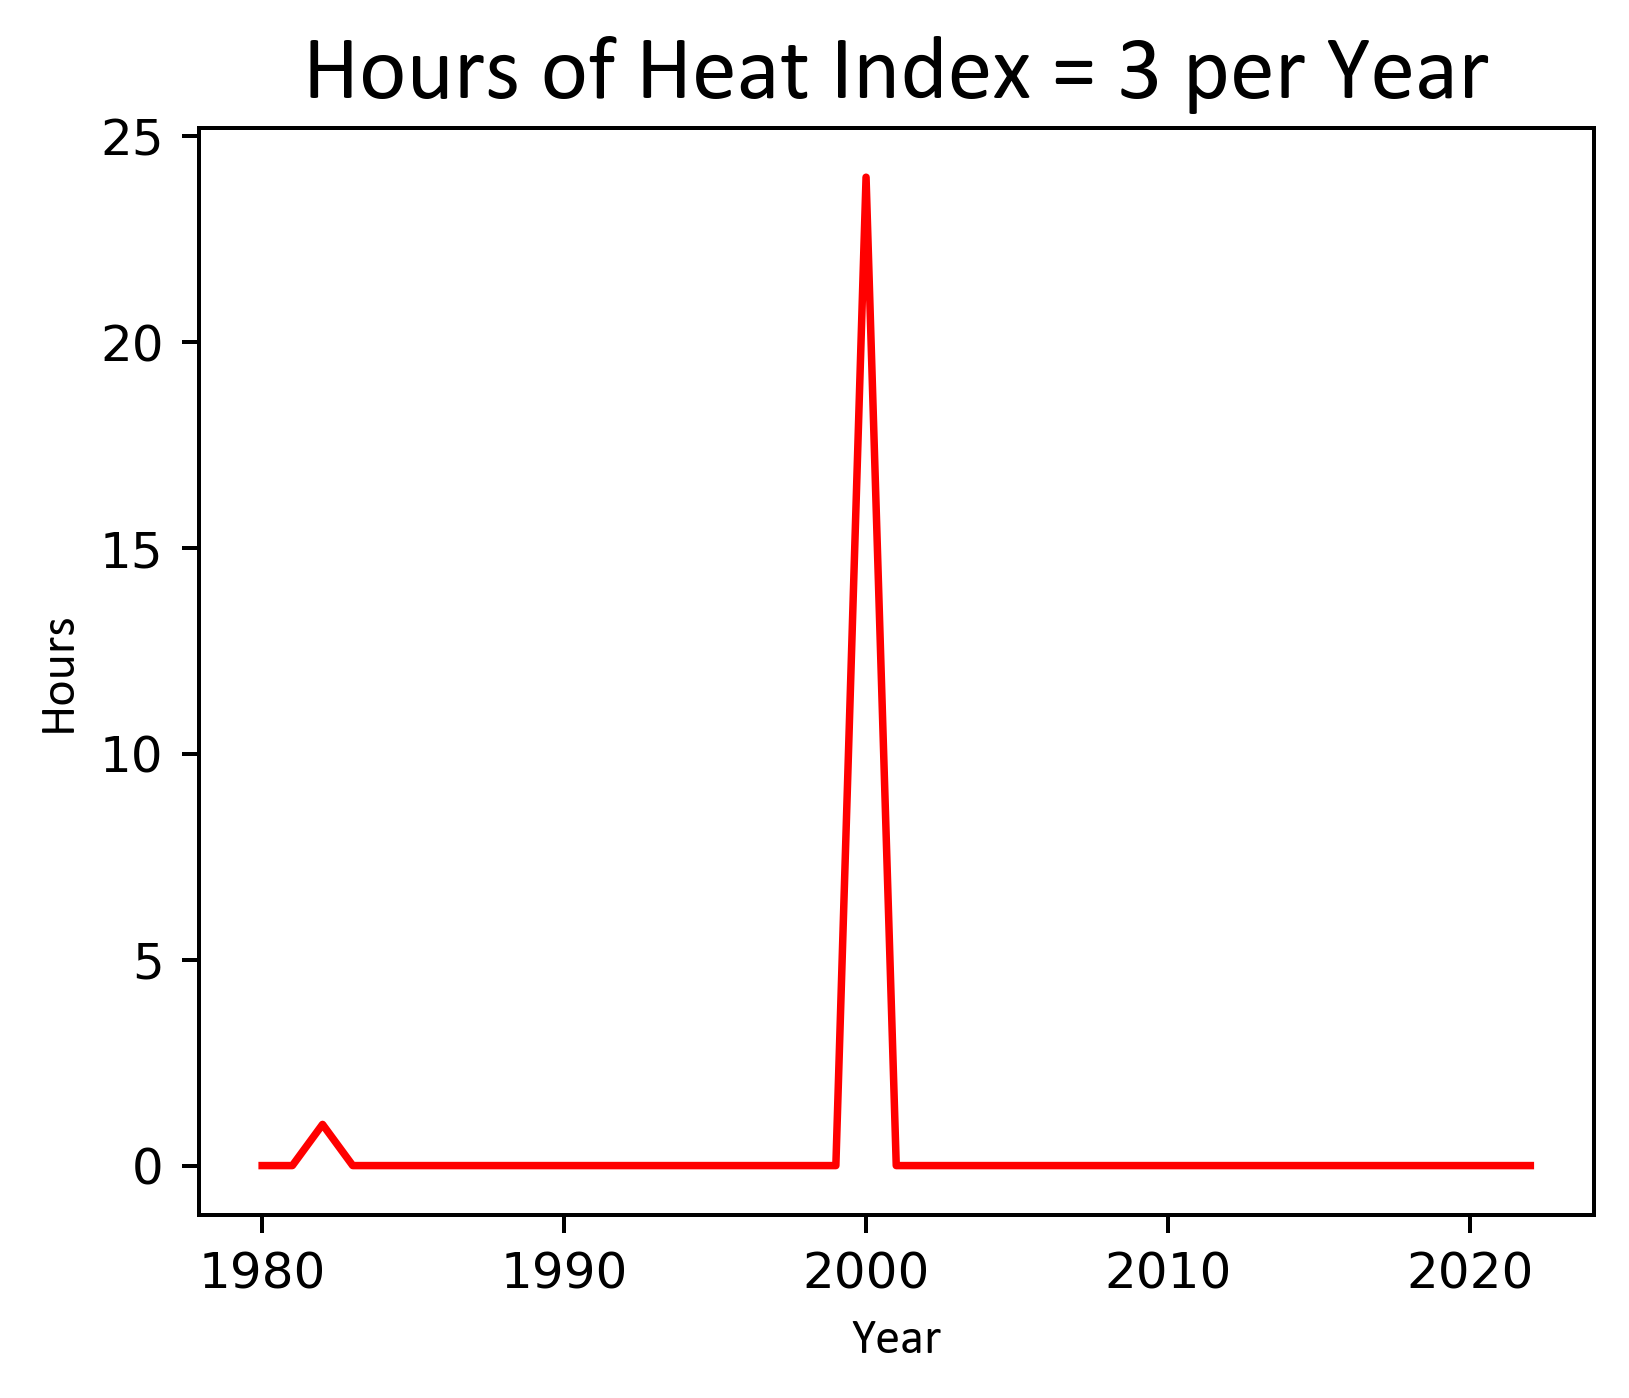

<Figure size 432x288 with 0 Axes>

In [19]:
f8=plt.figure(figsize=(5,4),dpi=360)
plt.plot(summary_weather['years'], summary_weather[3], color='r')

plt.title('Hours of Heat Index = 3 per Year',fontsize=titlesize,**labelfont)
plt.xlabel('Year',fontsize=ticksize,**labelfont)
plt.ylabel('Hours',fontsize=ticksize,**labelfont)
plt.show()
plt.savefig('output/heat_index_3_trend',bbox_inches="tight")

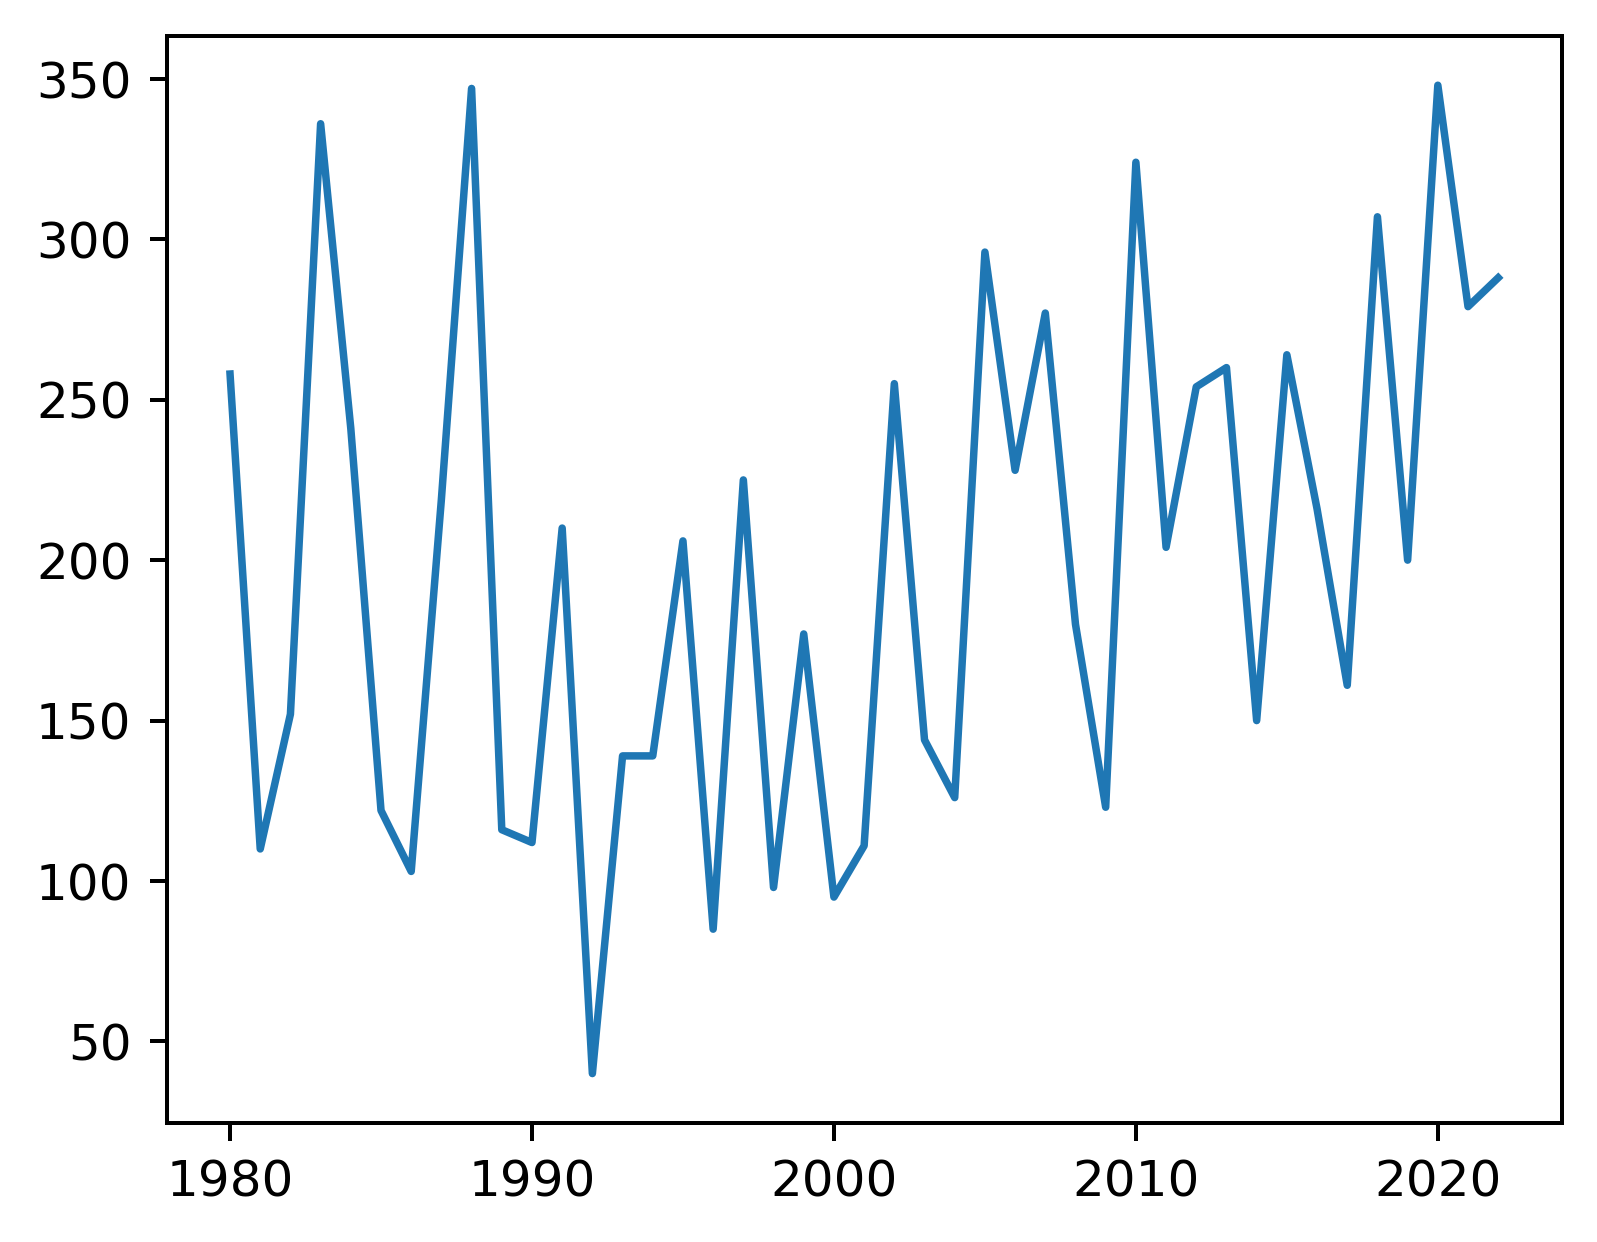

In [20]:
f8=plt.figure(figsize=(5,4),dpi=360)
plt.plot(summary_weather['years'], summary_weather[1] + summary_weather[2]+summary_weather[3]+summary_weather[4])